In [1]:
!pip install tensorflow opencv-python matplotlib

You should consider upgrading via the 'c:\users\raiyan samin\desktop\python\imageclassification\imageclassification\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import cv2
import imghdr
import os
import tensorflow as tf

In [51]:
data_dir = 'data'

In [52]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

## Remove sketchy images

In [53]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [54]:
import numpy as np
from matplotlib import pyplot as plt

In [55]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 176 files belonging to 2 classes.


In [56]:
data_iterator = data.as_numpy_iterator()

In [57]:
batch = data_iterator.next()

In [58]:
batch[1]

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1])

In [59]:
data = data.map(lambda x, y: (x / 255, y)) # Scales the data (transformation)

In [60]:
scaled_iterator = data.as_numpy_iterator()

In [61]:
batch = scaled_iterator.next()

In [62]:
batch[0].max()

1.0

## Training the model

In [63]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [64]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [66]:
model = Sequential()

In [67]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [68]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [70]:
logdir = 'logs'

In [71]:
tensorboard_callback =  tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [72]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 4s 761ms/step - loss: 1.3061 - accuracy: 0.6016 - val_loss: 1.0107 - val_accuracy: 0.4688
Epoch 2/20
4/4 [==============================] - 3s 734ms/step - loss: 0.8017 - accuracy: 0.5234 - val_loss: 0.6862 - val_accuracy: 0.5938
Epoch 3/20
4/4 [==============================] - 4s 720ms/step - loss: 0.6411 - accuracy: 0.6250 - val_loss: 0.5487 - val_accuracy: 0.6875
Epoch 4/20
4/4 [==============================] - 4s 811ms/step - loss: 0.5424 - accuracy: 0.6719 - val_loss: 0.4751 - val_accuracy: 0.9062
Epoch 5/20
4/4 [==============================] - 4s 786ms/step - loss: 0.4588 - accuracy: 0.8203 - val_loss: 0.3903 - val_accuracy: 0.9375
Epoch 6/20
4/4 [==============================] - 4s 764ms/step - loss: 0.4037 - accuracy: 0.8594 - val_loss: 0.3102 - val_accuracy: 0.9688
Epoch 7/20
4/4 [==============================] - 4s 739ms/step - loss: 0.3547 - accuracy: 0.8594 - val_loss: 0.2592 - val_accuracy: 0.9688
Epoch 8/20
4/4 [====

## Plotting the Loss and Accuracy

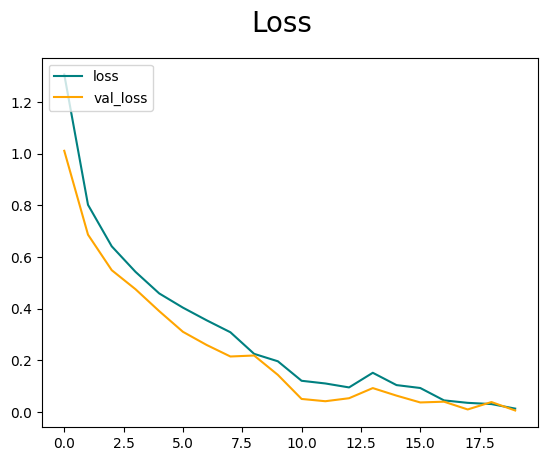

In [73]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

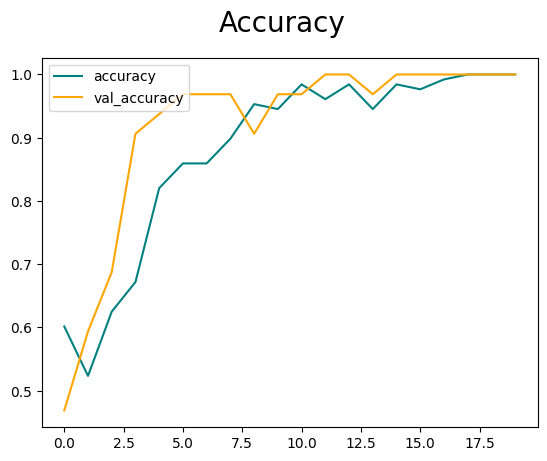

In [74]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Testing the model

In [75]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [76]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [77]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 91ms/step


In [78]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


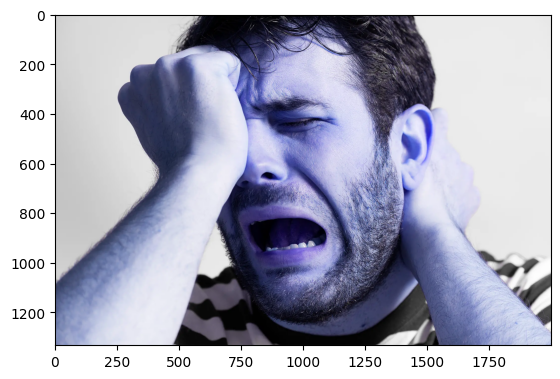

In [96]:
img = cv2.imread('sad person.jpg')
plt.imshow(img)
plt.show()

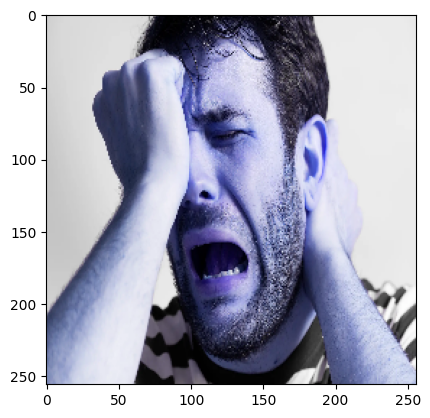

In [97]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [102]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 19ms/step


In [103]:
if yhat > 0.5:
    print('The prediction is sad with a value of {}'.format(yhat))
else: 
    print('The prediction is happy with a value of {}'.format(yhat))

The prediction is sad with a value of [[0.99591553]]


In [104]:
from tensorflow.keras.models import load_model

In [105]:
model.save(os.path.join('models', 'happysadmodel.h5'))